In [ ]:
pip install -U --quiet langgraph langchain_anthropic tavily-python

In [ ]:
# 准备大模型
# 这里可以用任意的model
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

In [ ]:
# 准备tools和tool execution
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

# 准备了一个search engine tool
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

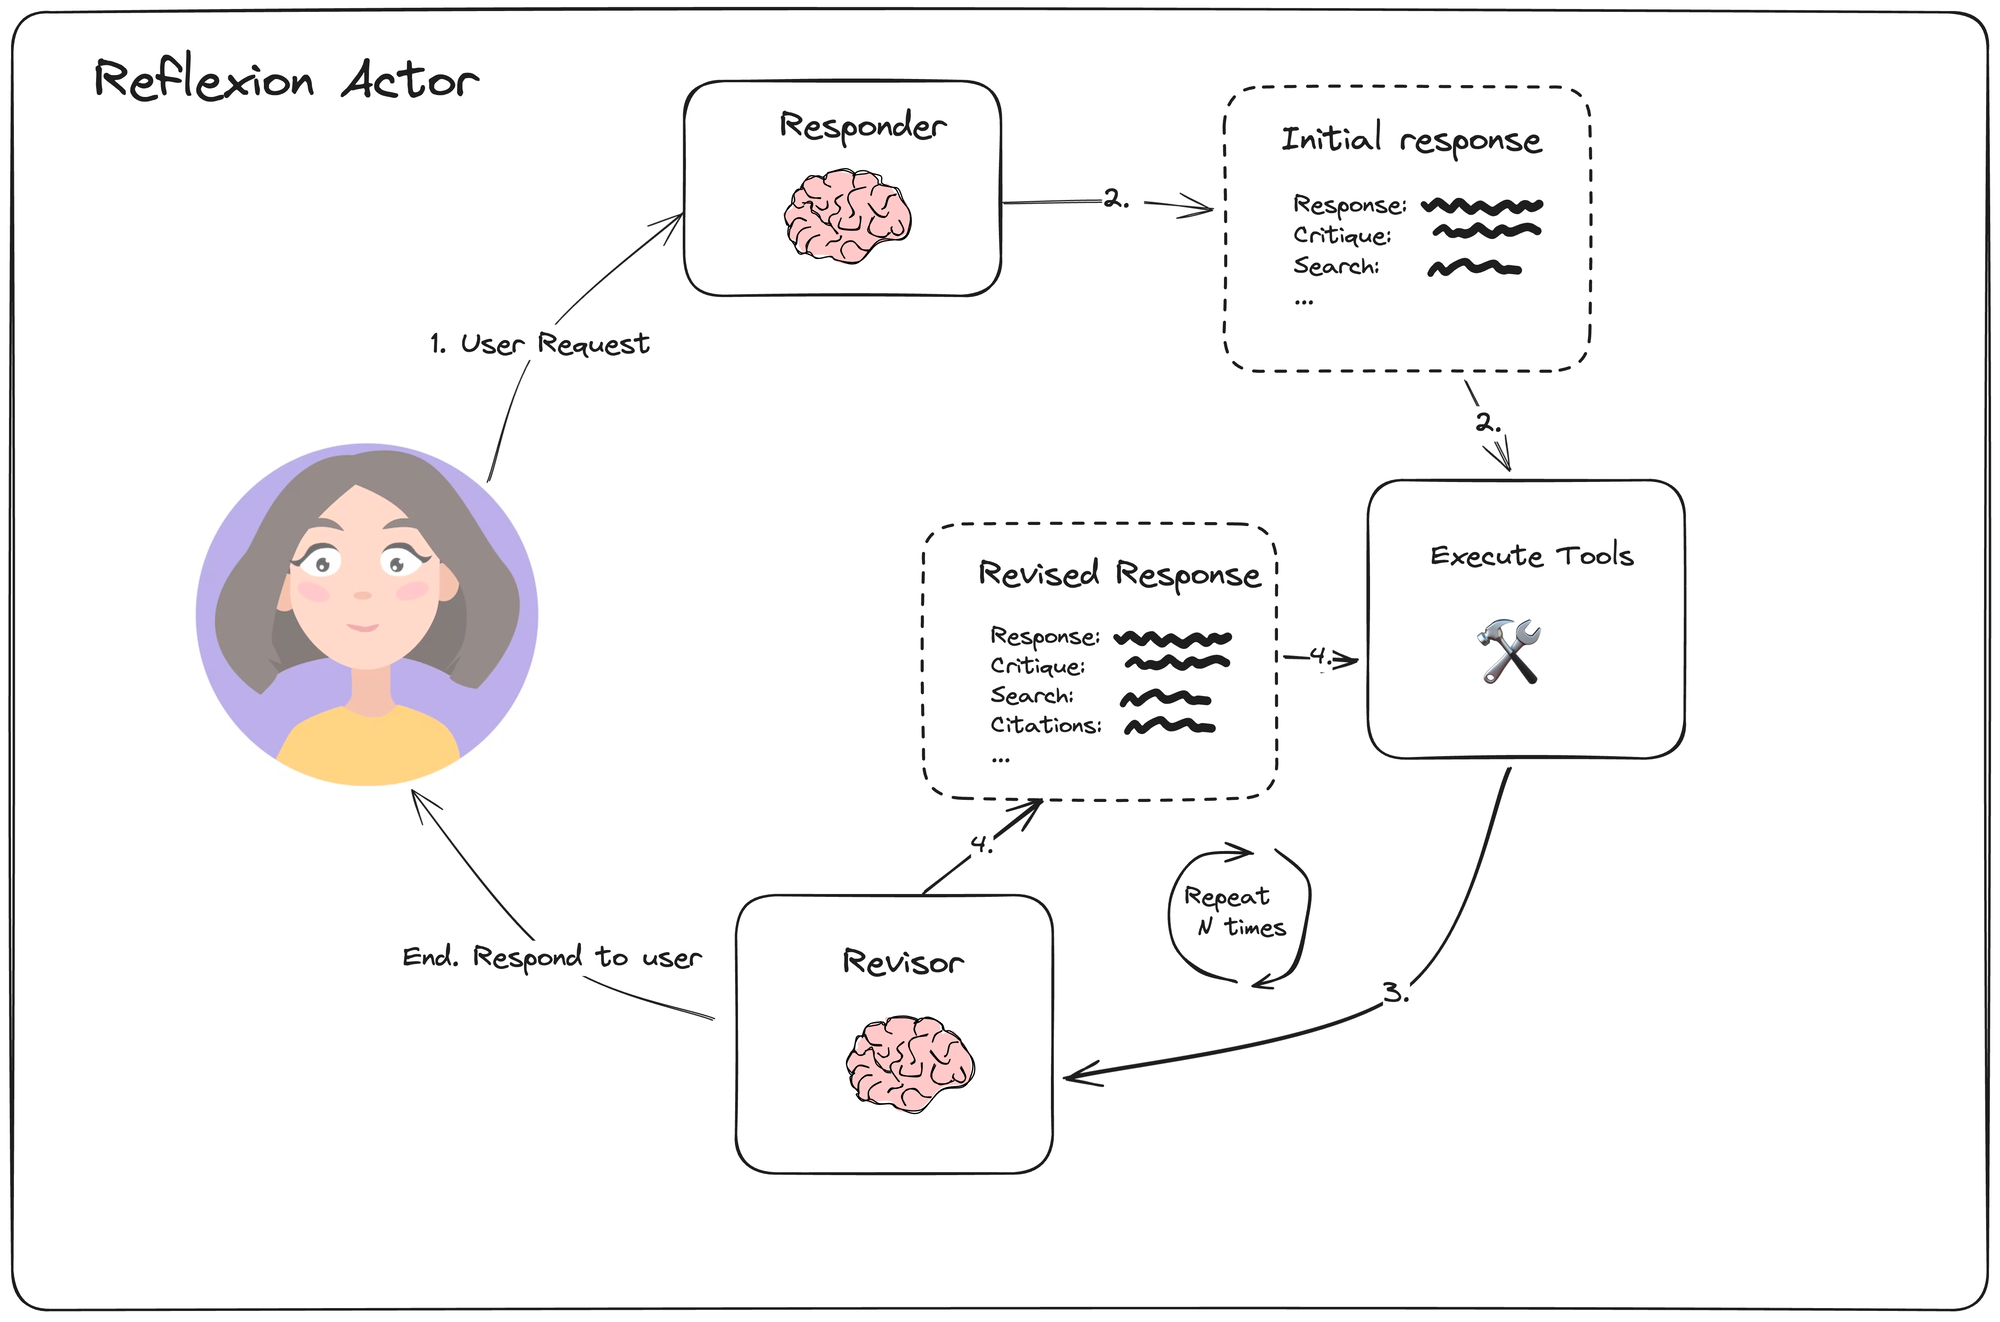


In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import ValidationError

from pydantic import BaseModel, Field
import datetime

# 用于捕捉回答中的Critique，确保critique内容不是缺失或者啰嗦
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")

# 封装问题的response，包含answer，reflection和search_queires三项
class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator
    # 尝试回答问题并且通过validator，最多尝试3次
    def respond(self, state: dict):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}



actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
# 生成初始的response
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [ ]:
# 初始回答例子
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

In [ ]:
# revision part
import json
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# 扩充answer的class 强制要求citation
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)
# example of revisor
revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial["messages"].tool_calls[0]["id"],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"][
                                "search_queries"
                            ][0]
                        }
                    )
                ),
            ),
        ]
    }
)
revised["messages"]

In [ ]:
# tool node用于执行tool
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [1]:
# 创建graph，让逻辑转起来
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

In [ ]:
# 生成一次reflexion的event
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()